## Прогнозирование цен на жилье с помощью нейросетевой регрессионной модели

Необходимо по имеющимся данным о ценах на жильё предсказать окончательную цену каждого дома с учетом характеристик домов с использованием нейронной сети. Описание набора данных  содержит 80 классов (набор переменых) классификации оценки типа жилья, и находится в файле `data_description.txt`.

В работе требуется дополнить раздел «Моделирование» в подразделе «Построение и обучение модели» создать и инициализировать последовательную модель нейронной сети с помощью фрэймворков тренировки нейронных сетей как: Torch или Tensorflow. Скомпилировать нейронную сеть выбрав функцию потерь и оптимизатор соответственно. Оценить точность полученных результатов. Вывести предсказанные данные о продаже. 


### Импорт библиотек
Импортируем необходимые библиотеки:

In [84]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

### Считываем набор данных


Загрузим набор данных и присвоим следующими переменные:

* `train_data`: данные, используемые для обучения модели
* `test_data`: данные, используемые для проверки модели

In [85]:
#Считываем набор данных
train_data = pd.read_csv('/content/data/notebook_files/test.csv') 
test_data = pd.read_csv('/content/data/notebook_files/train.csv')

## Подготовка данных
### Отобразим обучающие и проверочные данные:

In [88]:
#Отобразим обучающие и проверочные данные
print(train_data.head())

   Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0   1          60       RL  ...        WD         Normal    208500
1   2          20       RL  ...        WD         Normal    181500
2   3          60       RL  ...        WD         Normal    223500
3   4          70       RL  ...        WD        Abnorml    140000
4   5          60       RL  ...        WD         Normal    250000

[5 rows x 81 columns]


In [89]:
print(test_data.head())

     Id  MSSubClass MSZoning  ...  YrSold  SaleType SaleCondition
0  1461          20       RH  ...    2010        WD        Normal
1  1462          20       RL  ...    2010        WD        Normal
2  1463          60       RL  ...    2010        WD        Normal
3  1464          60       RL  ...    2010        WD        Normal
4  1465         120       RL  ...    2010        WD        Normal

[5 rows x 80 columns]


Как можно видеть, `train_data` имеет на один столбец больше, чем `test_data`, это столбец `SalePrice`, для обучения модели перед применением ее для предсказания меток в test_data.

### Проверяем нет ли тестовые данные пустых значений значений (Nan)

Построим функцию `def missing_value_checker` для проверки и подсчёта пропущеных значений в test_data. А также выведем тип данных этих значений.


In [90]:
# Построим функцию для проверки и подсчета пропущенных значений в test_data, выведем тип данных этих значений
def missing_value_checker(data):
    list = []
    for feature, content in data.items():
        if data[feature].isnull().values.any():
            
            sum = data[feature].isna().sum()

            type = data[feature].dtype

            print (f'{feature}: {sum}, type: {type}')
            
            list.append(feature)
    print(list)

    print(len(list))

missing_value_checker(test_data)

MSZoning: 4, type: object
LotFrontage: 227, type: float64
Alley: 1352, type: object
Utilities: 2, type: object
Exterior1st: 1, type: object
Exterior2nd: 1, type: object
MasVnrType: 16, type: object
MasVnrArea: 15, type: float64
BsmtQual: 44, type: object
BsmtCond: 45, type: object
BsmtExposure: 44, type: object
BsmtFinType1: 42, type: object
BsmtFinSF1: 1, type: float64
BsmtFinType2: 42, type: object
BsmtFinSF2: 1, type: float64
BsmtUnfSF: 1, type: float64
TotalBsmtSF: 1, type: float64
BsmtFullBath: 2, type: float64
BsmtHalfBath: 2, type: float64
KitchenQual: 1, type: object
Functional: 2, type: object
FireplaceQu: 730, type: object
GarageType: 76, type: object
GarageYrBlt: 78, type: float64
GarageFinish: 78, type: object
GarageCars: 1, type: float64
GarageArea: 1, type: float64
GarageQual: 78, type: object
GarageCond: 78, type: object
PoolQC: 1456, type: object
Fence: 1169, type: object
MiscFeature: 1408, type: object
SaleType: 1, type: object
['MSZoning', 'LotFrontage', 'Alley', 'Uti

Проверяем какие признаки в таблице можно оставить, а какие удалить. Если пропущенных значений слишком много, то удалим признак. Если их небольшое количество, то заполним `mean` или `median` для чисел, новая категория `missing` для строковых объектов.

В соответствии с этим:

– удалим ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'];

– заполним числовое отсутствующее значение значением `mean`;

– заполним строковое отсутствующее значение значением `missing`.

In [101]:
# удалим ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
test_edited = test_data.drop(['Alley','FireplaceQu','PoolQC', 'Fence', 'MiscFeature'], axis=1)
train_edited = train_data.drop(['Alley','FireplaceQu','PoolQC', 'Fence', 'MiscFeature'], axis=1)
# заполним числовое отсутствующее значение значением mean/ median, а строковое значением missing
def nan_filler(data):
    for label, content in data.items():
        if pd.api.types.is_numeric_dtype(content):
            data[label] = content.fillna(content.median())
        else:
            data[label] = content.astype("category").cat.as_ordered()
            data[label] = pd.Categorical(content).codes+1

nan_filler(test_edited)
nan_filler(train_edited)

### Перепроверим наши данные:

In [91]:
# Перепроверим данные
missing_value_checker(test_edited)

[]
0


In [55]:
missing_value_checker(train_edited)

[]
0


In [56]:
train_edited.shape, test_edited.shape

((1460, 76), (1459, 75))

In [57]:
test_edited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   int8   
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   int8   
 6   LotShape       1459 non-null   int8   
 7   LandContour    1459 non-null   int8   
 8   Utilities      1459 non-null   int8   
 9   LotConfig      1459 non-null   int8   
 10  LandSlope      1459 non-null   int8   
 11  Neighborhood   1459 non-null   int8   
 12  Condition1     1459 non-null   int8   
 13  Condition2     1459 non-null   int8   
 14  BldgType       1459 non-null   int8   
 15  HouseStyle     1459 non-null   int8   
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

In [58]:
train_edited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   int8   
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   int8   
 6   LotShape       1460 non-null   int8   
 7   LandContour    1460 non-null   int8   
 8   Utilities      1460 non-null   int8   
 9   LotConfig      1460 non-null   int8   
 10  LandSlope      1460 non-null   int8   
 11  Neighborhood   1460 non-null   int8   
 12  Condition1     1460 non-null   int8   
 13  Condition2     1460 non-null   int8   
 14  BldgType       1460 non-null   int8   
 15  HouseStyle     1460 non-null   int8   
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

### Разделим данные

Поскольку мы не знаем метку (Цена) тестовых данных, для оценки модели, чтобы получить лучшую модель перед прогнозированием тестовых данных, разделим данные в файле train.scv на обучающие и проверочные данные, соотношение составляет 20%.

In [92]:
# Разделим данные в файле train.scv на обучающие и проверочные с соотношением 20%
X = train_edited.drop('SalePrice', axis=1)
y = train_edited['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)


In [93]:
X_train.shape, test_edited.shape

((1168, 75), (1459, 75))

## Моделирование

### Построение и обучение модели


Создайте последовательную модель нейронной сети с помощью фрэймворков тренировки нейронных сетей как: Torch или Tensorflow. 

In [94]:
# Создание последовательной модели нейронной сети 
model = keras.Sequential([
    layers.Dense(150, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(1)
])

Скомпилируйте нейронную сеть, выбрав функцию потерь и оптимизатор соответственно.

In [95]:
# Скомпилировали нейронную сеть, выбрав функцию потерь и оптимизатор
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01), metrics=['mae'])

Обучите модель на обучающих данных `X_train` и `y_train` задав гиперпараметры вашей модели нейронной сети, например количество эпох (epochs), размер мини-выборки (batch_size) и другие.

In [96]:
# Обучили модель, задав гиперпараметры (количество эпох, размер мини - выборки)
history = model.fit(X, y, validation_split=0.2, verbose=1, epochs=40, batch_size=100)

Epoch 1/40
12/12 [==============================] - 1s 22ms/step - loss: 25149247488.0000 - mae: 133250.0000 - val_loss: 6594354176.0000 - val_mae: 52121.3281
Epoch 2/40
12/12 [==============================] - 0s 4ms/step - loss: 9089185792.0000 - mae: 51123.8125 - val_loss: 5165691392.0000 - val_mae: 44769.3281
Epoch 3/40
12/12 [==============================] - 0s 4ms/step - loss: 4400100864.0000 - mae: 43442.2188 - val_loss: 4255990528.0000 - val_mae: 44985.2461
Epoch 4/40
12/12 [==============================] - 0s 4ms/step - loss: 3227517952.0000 - mae: 39801.1797 - val_loss: 3798822400.0000 - val_mae: 40268.5859
Epoch 5/40
12/12 [==============================] - 0s 4ms/step - loss: 2843216384.0000 - mae: 37669.3750 - val_loss: 3556399872.0000 - val_mae: 38830.3750
Epoch 6/40
12/12 [==============================] - 0s 5ms/step - loss: 2466062592.0000 - mae: 35191.1719 - val_loss: 3381401088.0000 - val_mae: 36103.2812
Epoch 7/40
12/12 [==============================] - 0s 4ms/st

**Оцените полученные результаты**

{'loss': [25149247488.0, 9089185792.0, 4400100864.0, 3227517952.0, 2843216384.0, 2466062592.0, 2129504128.0, 1882322304.0, 1716818304.0, 1655310848.0, 1580684928.0, 1599340032.0, 1544887296.0, 1572882560.0, 1585863168.0, 1558873216.0, 1515012352.0, 1531994112.0, 1476278784.0, 1477924608.0, 1561404928.0, 1464889984.0, 1472826368.0, 1566506240.0, 1480499200.0, 1427411456.0, 1429376640.0, 1451577984.0, 1546053248.0, 1468764800.0, 1424315648.0, 1421523328.0, 1409204096.0, 1389347840.0, 1437709440.0, 1388603776.0, 1384645504.0, 1366191360.0, 1374868608.0, 1382305152.0], 'mae': [133250.0, 51123.8125, 43442.21875, 39801.1796875, 37669.375, 35191.171875, 31200.232421875, 29408.1875, 27853.904296875, 27284.0, 26597.142578125, 26752.578125, 26104.818359375, 26257.466796875, 26580.62109375, 26128.28515625, 25415.669921875, 26428.6015625, 25183.103515625, 25493.12890625, 26170.03515625, 25470.17578125, 24935.603515625, 25661.150390625, 25608.021484375, 24893.642578125, 24439.03515625, 24549.976562

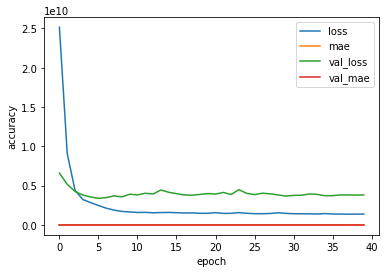

In [97]:
# Оценка полученных результатов
pd.DataFrame(history.history).plot()
plt.ylabel('accuracy')
plt.xlabel('epoch')
print(history.history)

In [81]:
scores = model.evaluate(X_val, y_val, verbose=1)

10/10 [==============================] - 0s 2ms/step - loss: 1251861248.0000 - mae: 24653.3945


### Предсказание

In [98]:
# Предсказание
preds = model.predict(test_edited)
preds

array([[148246.28],
       [190870.55],
       [187232.3 ],
       ...,
       [187638.78],
       [101181.27],
       [233958.72]], dtype=float32)

In [99]:
output = pd.DataFrame(
{
    'Id':test_data['Id'],
    'SalePrice': np.squeeze(preds)
})
output

,Id,SalePrice
0,1461,148246.281250
1,1462,190870.546875
2,1463,187232.296875
3,1464,186016.718750
4,1465,174819.343750
...,...,...
1454,2915,83726.859375
1455,2916,103271.210938
1456,2917,187638.781250
1457,2918,101181.273438



**При выполнении:**

Выведите отчет нейросетевой регрессионной модели, для  прогнозирование цен на жилье. 

Подберить разные комбинации гиперпараметров таким образом, чтобы получить лучший результат на тестовом наборе данных.

Попробуйте использовать разное количество нейронов на входном слое, например 100, 150, 200 300.

Добавьте в нейронную сеть скрытый слой с разным количеством нейронов.

Используйте разное количество эпох: 10, 15, 20, 25, 30.

Используйте разные размеры мини-выборки (batch_size): 10, 50, 100, 200.

Попробуйте использовать разные значения оптимизатора `optimizers` и функции потерь `loss`. Сравните полученые результаты.

**Вопросы:**

Как выше перечисленные параметры влияют на полученный вами результат? 

Что такое эпоха (Epoch)? В чем отличие от итерации (Iteration)?

Что такое функция активации? Какие вам известны?

Что такое MSE(Mean Squared Error) - Средняя квадратичная ошибка? Что такое MAE(Mean Absolute Error)? Для чего используются.